In [5]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from skimage import io, transform
from sklearn import preprocessing
from tqdm.notebook import tqdm, trange
import anndata as ad
import tifffile
import pickle
from skimage.segmentation import relabel_sequential

In [6]:
p_dir = (Path().cwd().parents[0].parents[0]).absolute()
data_raw = p_dir / "graph"
data_dir = (Path().cwd().parents[0]).absolute() / 'data'

In [7]:
spatial_omics_folder = (Path().cwd().parents[0]).absolute() / 'data' / 'spatial_omics_graph_external'
spatial_omics_folder.mkdir(exist_ok=True, parents=True)


In [8]:
# Import spatial omics library
import athena as ath
from spatialOmics import SpatialOmics

# import default graph builder parameters
from athena.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS

# Breast IMC 2

## Transform to adata

In [9]:
# Define folder
dataset_dir = data_raw / 'Breast IMC 2'
masks_folder = dataset_dir / 'cell_masks'

# Read processed single cell data
sc_data_path = dataset_dir / 'single_cell_data.csv'
df = pd.read_csv(sc_data_path)

FileNotFoundError: [Errno 2] No such file or directory: 'Y:\\coskun-lab\\Efe and Nishkala\\SnowflakePipeline\\graph\\Breast IMC 2\\single_cell_data.csv'

In [29]:
columns = df.columns.tolist()
markers = columns[4:-5]
obs_columns = columns[:4] + columns[-5:]

In [30]:
adata = sc.AnnData(df[markers].values)
adata.var_names = markers
adata.obs = df[obs_columns]
adata.obsm['spatial'] = df[['Location_Center_X', 'Location_Center_Y']].values

In [31]:
adata.obs

metabricId  core_id  ImageNumber  ObjectNumber  Location_Center_X  \
0         MB-0000        1          527             1          161.83333   
1         MB-0000        1          527             2          177.30435   
2         MB-0000        1          527             3          293.51898   
3         MB-0000        1          527             4          165.04347   
4         MB-0000        1          527             5          108.88095   
...           ...      ...          ...           ...                ...   
479839    MB-0921        1          381          2080          440.20001   
479840    MB-0921        1          381          2081          447.57895   
479841    MB-0921        1          381          2082          403.16666   
479842    MB-0921        1          381          2083          308.53845   
479843    MB-0921        1          381          2084          432.69696   

        Location_Center_Y  SOM_nodes  pg_cluster        description  
0                6.000000          6          24        Fibroblasts  
1               15.539130          6          24        Fibroblasts  
2               19.886076          6          24        Fibroblasts  
3               22.210144          4          20  Fibroblasts CD68+  
4               28.523809          6          24        Fibroblasts  
...                   ...        ...         ...                ...  
479839         582.400020         99          54           HR- CK7-  
479840         583.157900         83          28        HRlow CKlow  
479841         583.142880         67          45        HRlow CKlow  
479842         585.230770         20          21        Fibroblasts  
479843         585.272710        124          28        HRlow CKlow  

[479844 rows x 9 columns]

In [32]:
sc.pp.scale(adata, max_value=5)

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
... storing 'metabricId' as categorical
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
... storing 'description' as categorical


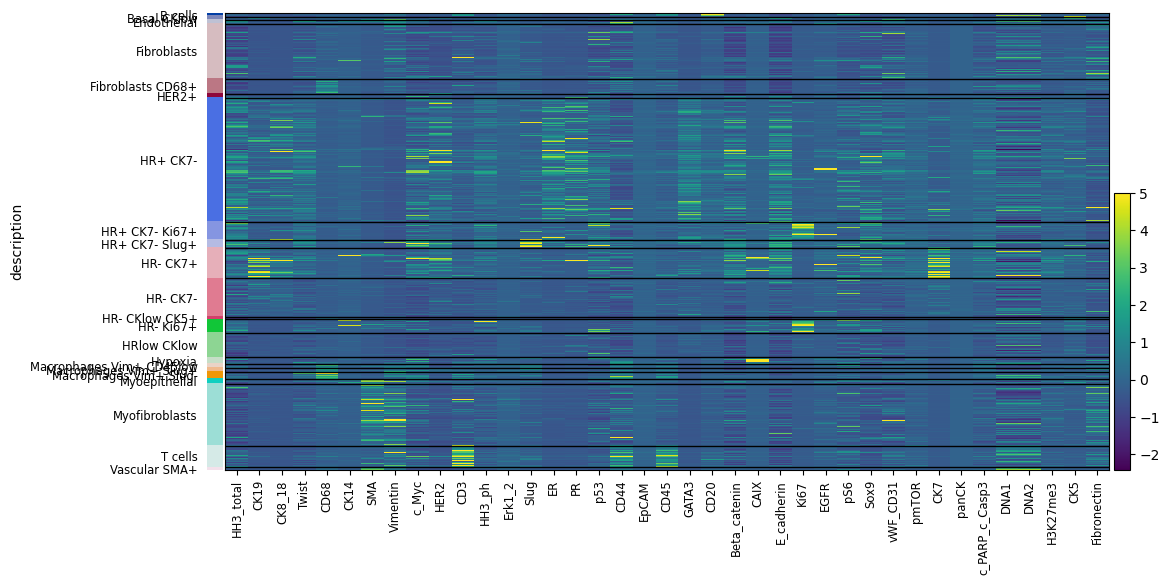

In [33]:
sc.pl.heatmap(adata, adata.var_names, groupby='description')

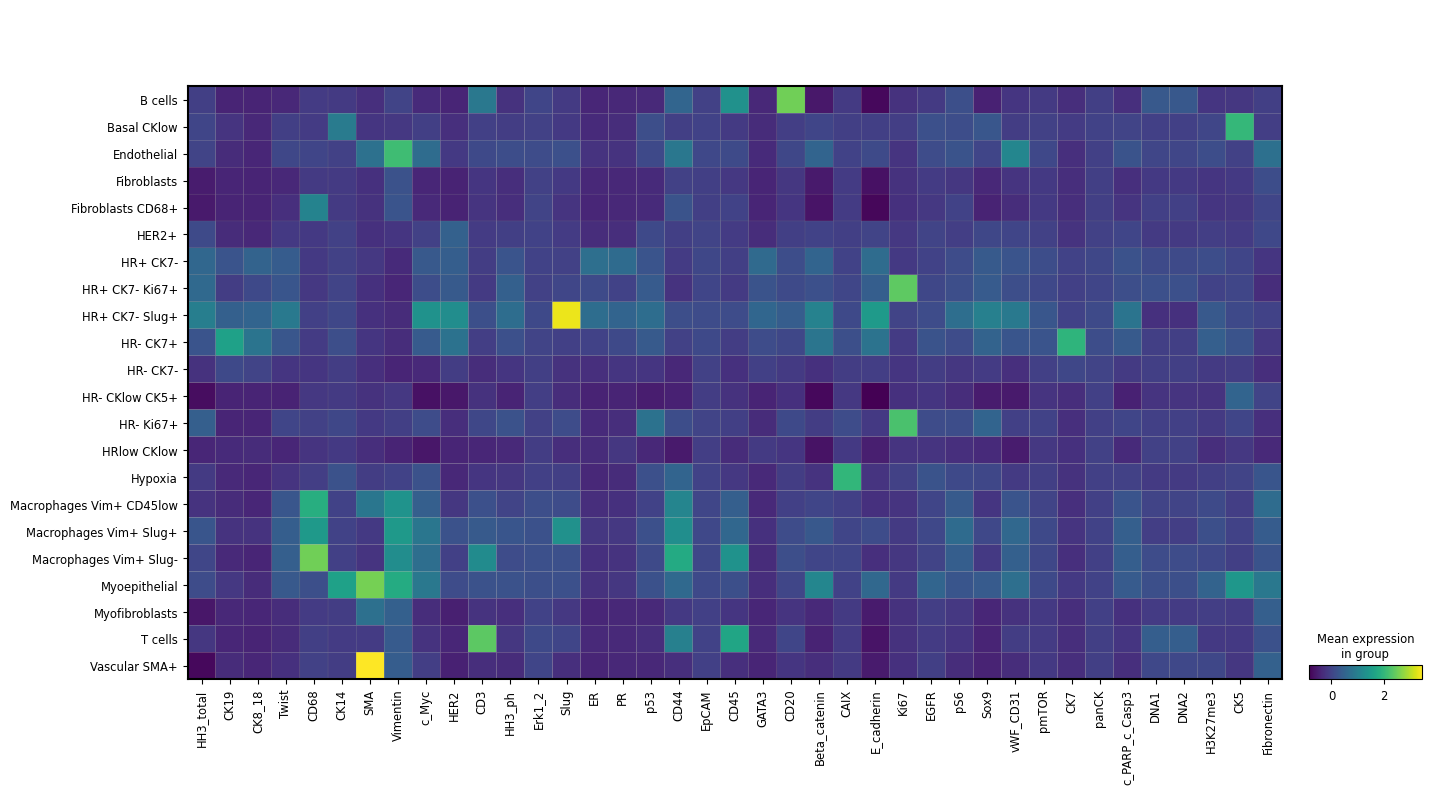

In [35]:
sc.pl.matrixplot(adata, adata.var_names, groupby='description')

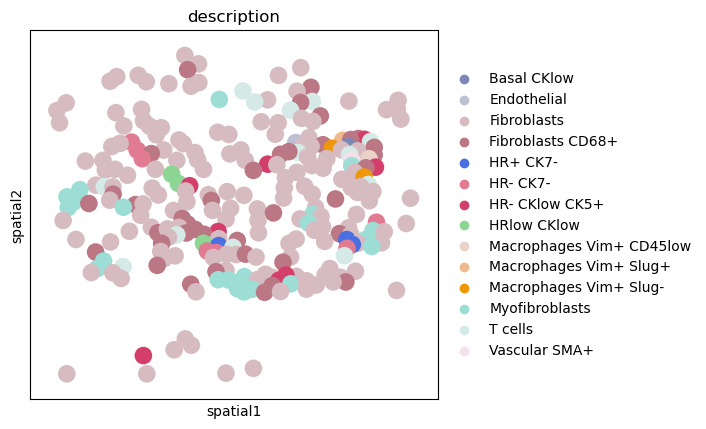

In [36]:
for im in adata.obs.ImageNumber.unique()[:10]:
    adata_subset = adata[adata.obs.ImageNumber == im]

    sc.pl.spatial(adata_subset, color='description', spot_size=20)
    break

In [37]:
adata[adata.obs['metabricId'] == 'MB-0077'].obs

metabricId  core_id  ImageNumber  ObjectNumber  Location_Center_X  \
21051    MB-0077        1           81             1         501.014500   
21052    MB-0077        1           81             2         290.405400   
21053    MB-0077        1           81             3         183.593750   
21054    MB-0077        1           81             4          98.111115   
21055    MB-0077        1           81             5         224.562500   
...          ...      ...          ...           ...                ...   
22716    MB-0077        2          136           976         566.409120   
22717    MB-0077        2          136           977         138.672840   
22718    MB-0077        2          136           978         171.705890   
22719    MB-0077        2          136           979         150.023530   
22720    MB-0077        2          136           980         162.442630   

       Location_Center_Y  SOM_nodes  pg_cluster     description  
21051           5.434782          6          24     Fibroblasts  
21052           4.513514          6          24     Fibroblasts  
21053           6.750000          7          11  Myofibroblasts  
21054           6.777778          7          11  Myofibroblasts  
21055           6.875000          6          24     Fibroblasts  
...                  ...        ...         ...             ...  
22716         534.000000         84          45     HRlow CKlow  
22717         535.481510         87          54        HR- CK7-  
22718         536.058840        103          46        HR- CK7+  
22719         539.152950         87          54        HR- CK7-  
22720         538.745910        103          46        HR- CK7+  

[1670 rows x 9 columns]

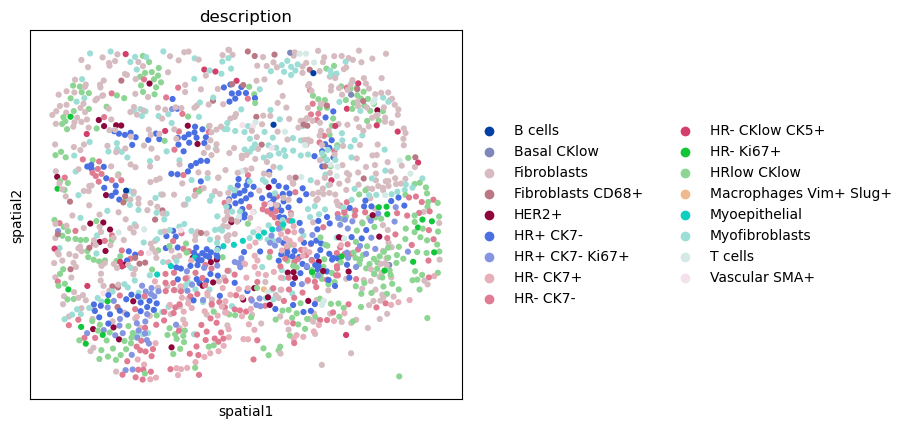

In [38]:
sc.pl.spatial(adata[adata.obs['metabricId'] == 'MB-0077'], color='description',spot_size=10)

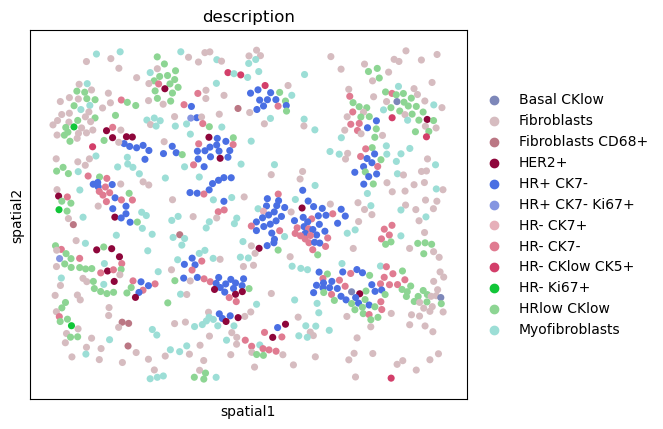

In [39]:
sc.pl.spatial(adata[adata.obs['ImageNumber'] == 81], color='description',spot_size=10)

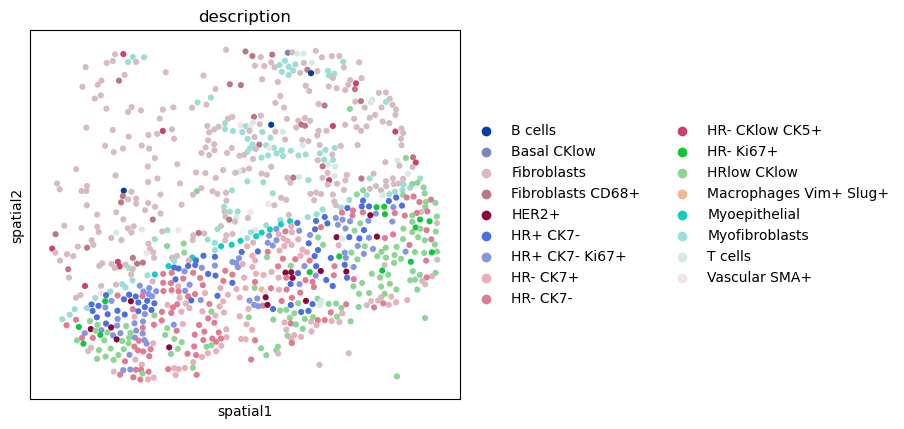

In [40]:
sc.pl.spatial(adata[adata.obs['ImageNumber'] == 136], color='description',spot_size=10)

In [41]:
save_path = (Path().cwd().parents[0]).absolute() / 'data' / 'adata'
adata.write_h5ad(save_path / 'breast.h5ad')

## Create spatial omcs dataset

In [41]:
import matplotlib 
from matplotlib.colors import ListedColormap, Normalize

# Extract colormap
var = 'description'

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

# Create cmap for spatial omics data
cmap_labels = {i:l for i,l in enumerate(labels)}
label_cmap = {l:i for i,l in enumerate(labels)}
cmap = np.array([colors_rgb_dict[l] for l in labels])
adata.obs['meta_id'] = adata.obs[var].apply(lambda x: label_cmap.get(x,x))
adata.obs

C:\Users\thu71\AppData\Local\Temp\ipykernel_11072\537673100.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['meta_id'] = adata.obs['description'].apply(lambda x: label_cmap.get(x,x))


metabricId  core_id  ImageNumber  ObjectNumber  Location_Center_X  \
0         MB-0000        1          527             1          161.83333   
1         MB-0000        1          527             2          177.30435   
2         MB-0000        1          527             3          293.51898   
3         MB-0000        1          527             4          165.04347   
4         MB-0000        1          527             5          108.88095   
...           ...      ...          ...           ...                ...   
479839    MB-0921        1          381          2080          440.20001   
479840    MB-0921        1          381          2081          447.57895   
479841    MB-0921        1          381          2082          403.16666   
479842    MB-0921        1          381          2083          308.53845   
479843    MB-0921        1          381          2084          432.69696   

        Location_Center_Y  SOM_nodes  pg_cluster        description meta_id  
0                6.000000          6          24        Fibroblasts       3  
1               15.539130          6          24        Fibroblasts       3  
2               19.886076          6          24        Fibroblasts       3  
3               22.210144          4          20  Fibroblasts CD68+       4  
4               28.523809          6          24        Fibroblasts       3  
...                   ...        ...         ...                ...     ...  
479839         582.400020         99          54           HR- CK7-      10  
479840         583.157900         83          28        HRlow CKlow      13  
479841         583.142880         67          45        HRlow CKlow      13  
479842         585.230770         20          21        Fibroblasts       3  
479843         585.272710        124          28        HRlow CKlow      13  

[479844 rows x 10 columns]

In [42]:
# Generate spatial omics dataframe
data_name = 'Breast_IMC_2'
identifier = 'ImageNumber'
cell_id = 'ObjectNumber'
spatial_path = spatial_omics_folder / f'{data_name}.hdf5'

# Get image id 
im_ids = sorted(adata.obs[identifier].unique())

In [43]:
# Create spatial omics
spadata = SpatialOmics()
spl = pd.DataFrame({identifier:  im_ids})
spadata.spl = spl

# Loop through images
for im_id in tqdm(im_ids):
    # Get subset adata
    adata_subset = adata[adata.obs[identifier] == im_id, :]
    obs = adata_subset.obs.copy()
    obs.index = obs[cell_id].tolist()
    obs['x'] = adata_subset.obsm['spatial'][:,0]
    obs['y'] = adata_subset.obsm['spatial'][:,1]
    info = adata_subset.obs.iloc[0]

    # Read mask
    meta_id = info['metabricId'].replace('-', '')
    core_id = info['core_id']
    mask_path = masks_folder / f'{meta_id}_{core_id}_{im_id}_cellmask.tiff'
    try:
        mask = skimage.io.imread(mask_path)
    except:
        print(f'Error for {mask_path}')
        continue 
    
    # Add single-cell data 
    spadata.obs[im_id] = obs
    spadata.X[im_id] = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names.tolist(), index=obs[cell_id].tolist())
    spadata.var[im_id] = adata_subset.var
    
    # Filter out cell in mask not present in dataframe
    cell_list = obs[cell_id].tolist()
    mask_list = list(np.unique(mask))
    diff = list(set(mask_list).difference(cell_list))
    mask = np.where(np.isin(mask, diff), 0, mask)

    # Add mask to spadata
    spadata.masks[im_id] = {'cellmasks': mask}
    ath.pp.extract_centroids(spadata, im_id, mask_key='cellmasks')

# Add colormap to spatial omics data
spadata.uns['cmaps'].update({'meta_id': ListedColormap(cmap / 255)})
spadata.uns['cmap_labels'].update({'meta_id': cmap_labels})



  0%|          | 0/548 [00:00<?, ?it/s]

In [44]:
# spadata.obs[im_id][['x', 'y', 'Location_Center_X', 'Location_Center_Y']]

In [45]:
# spadata.obs[1]

1


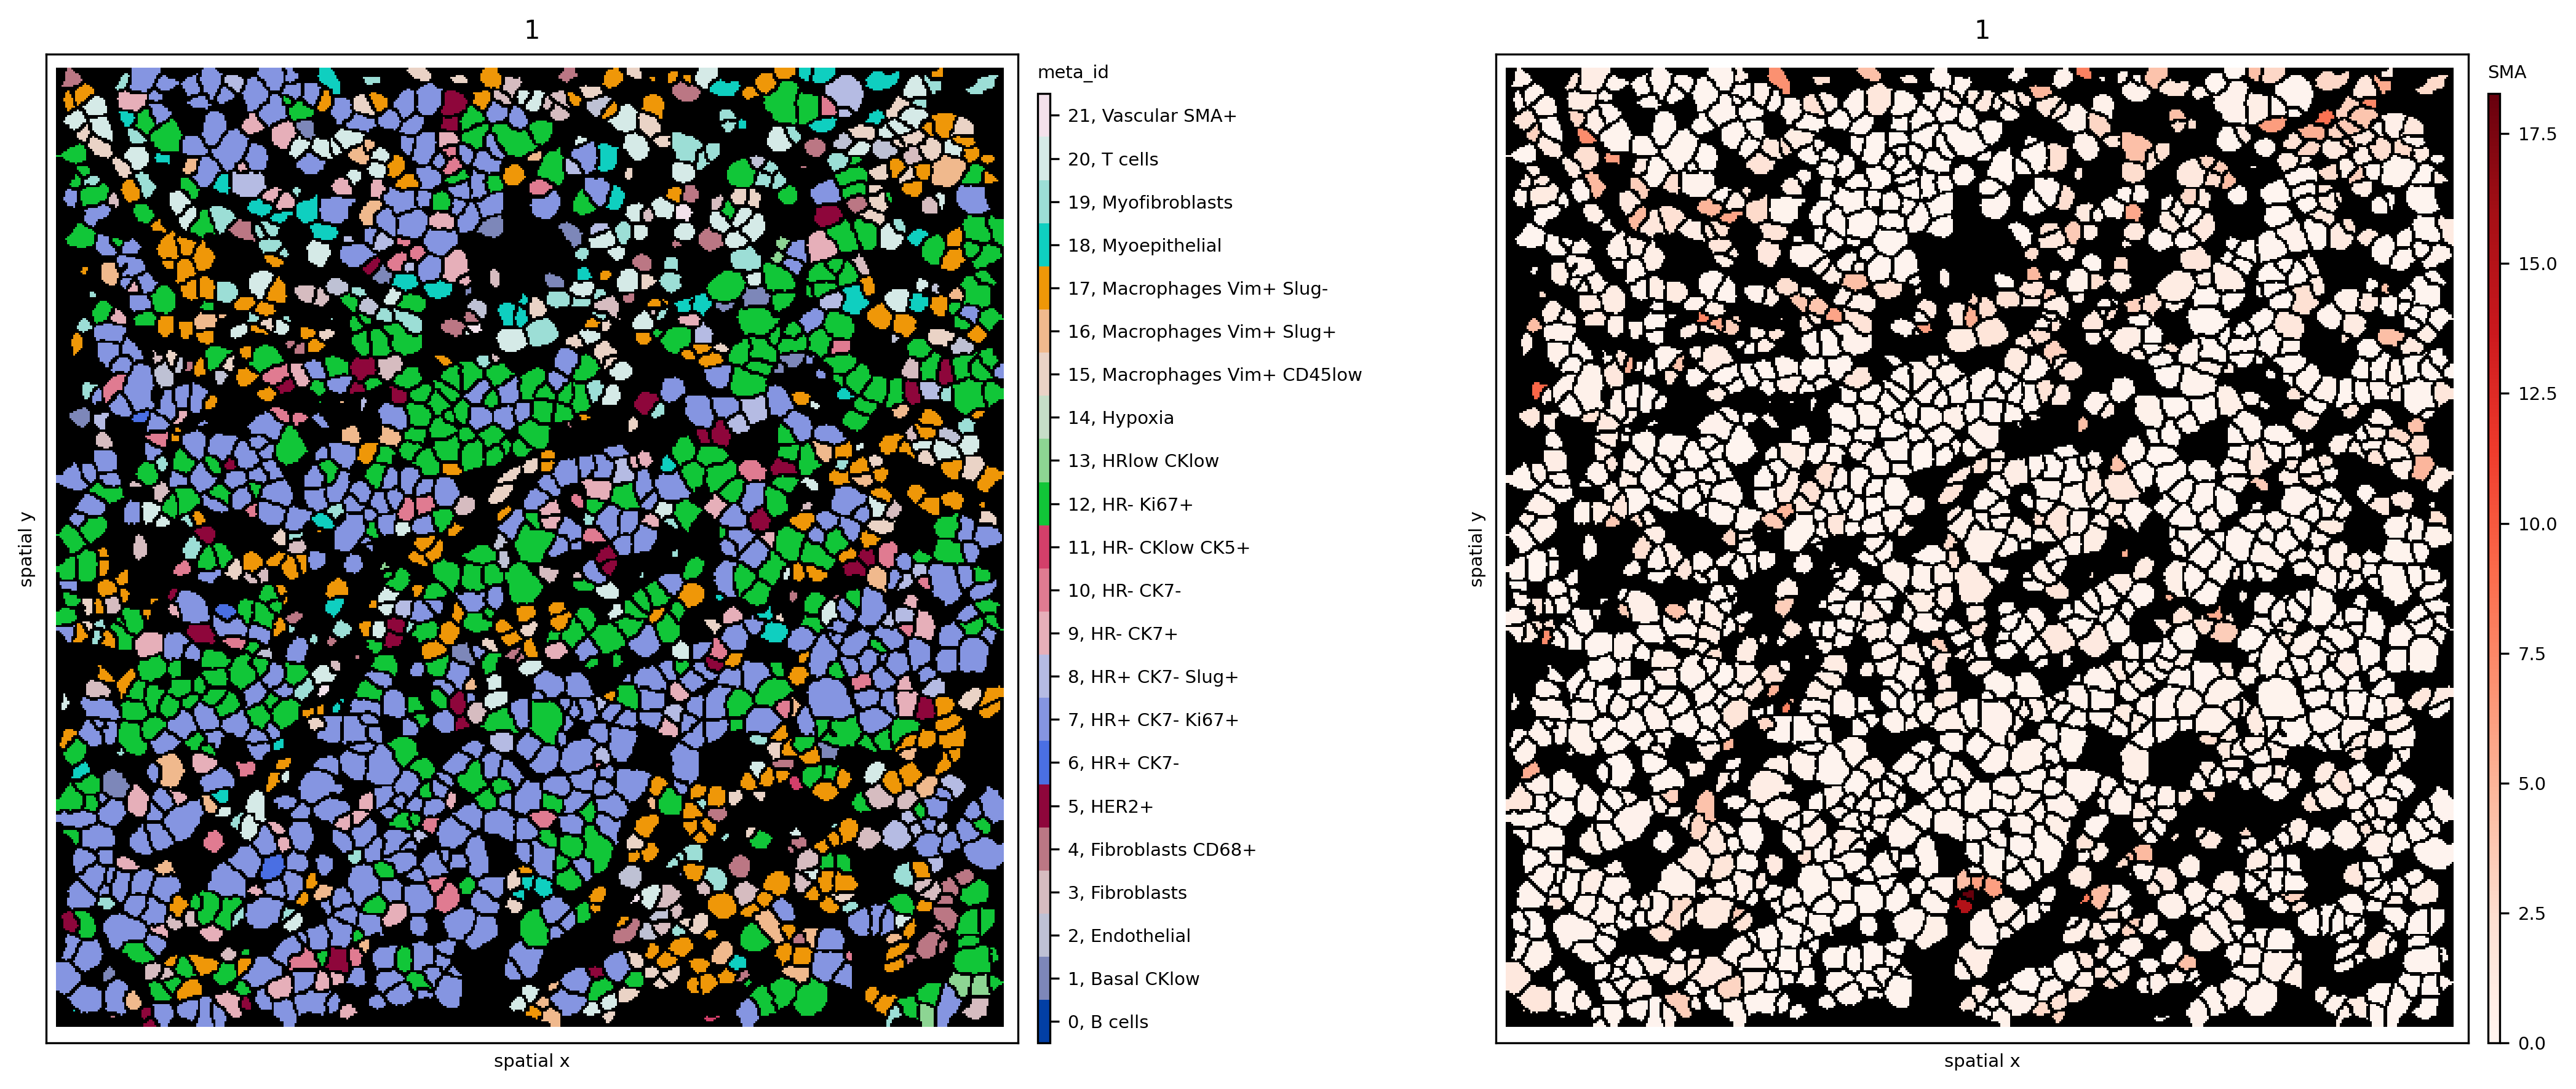

In [46]:
for im_id in spadata.spl[identifier].unique():
    print(im_id)
    # im_id = str(im_id)
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
    ath.pl.spatial(spadata, im_id, 'meta_id', mode='mask', ax=axs.flat[0],background_color='black')
    ath.pl.spatial(spadata, im_id, 'SMA', mode='mask', ax=axs.flat[1], background_color='black')
    break

In [47]:
# Create graph for different type
from athena.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS

for im_id in spadata.spl[identifier].unique():
    # kNN graph
    config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
    config['builder_params']['n_neighbors'] = 6 # set parameter k
    ath.graph.build_graph(spadata, im_id, builder_type='knn', mask_key='cellmasks', config=config)

    # radius graph
    config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
    config['builder_params']['radius'] = 20 # set radius
    ath.graph.build_graph(spadata, im_id, builder_type='radius', mask_key='cellmasks', config=config)

    # contact graph - this takes some time
    ath.graph.build_graph(spadata, im_id, builder_type='contact', mask_key='cellmasks')

100%|██████████| 1771/1771 [00:15<00:00, 112.53it/s]


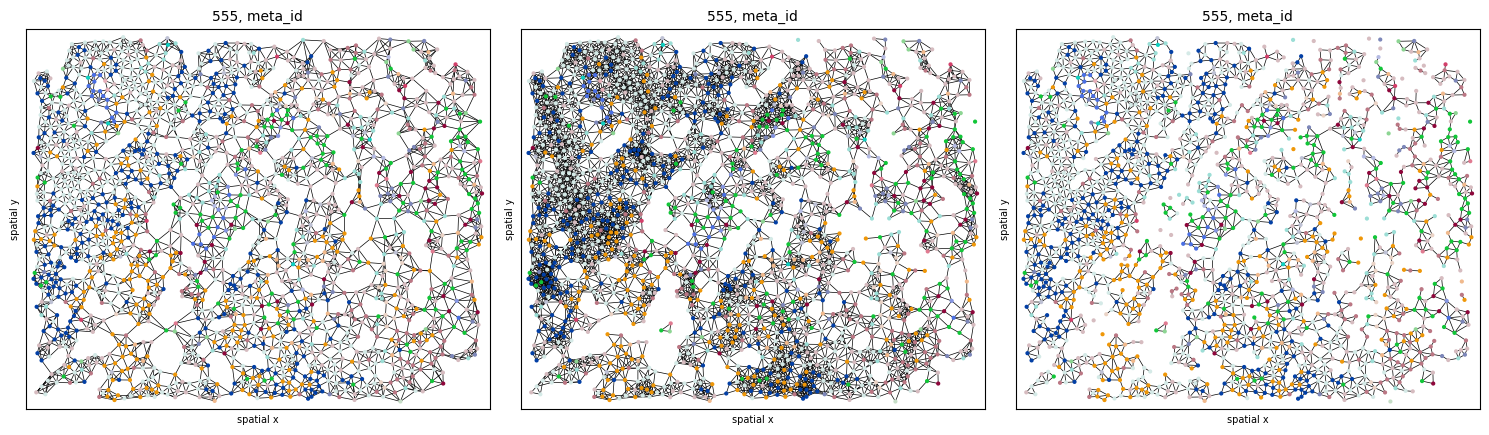

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6), dpi=100)
ath.pl.spatial(spadata, im_id, 'meta_id', edges=True, graph_key='knn', ax=axs.flat[0], cbar=False)
ath.pl.spatial(spadata, im_id, 'meta_id', edges=True, graph_key='radius', ax=axs.flat[1], cbar=False)
ath.pl.spatial(spadata, im_id, 'meta_id', edges=True, graph_key='contact', ax=axs.flat[2], cbar=False)


In [49]:
# Save data
spatial_path = spatial_omics_folder / f'{data_name}.hdf5'
spadata.to_h5py(spatial_path)

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\spatialOmics\spatialOmics.py:193: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  self.spl.to_hdf(file, 'spl', format="table")
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\spatialOmics\spatialOmics.py:198: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  self.var[spl].to_hdf(file, f'var/{spl}', format="table")
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\spatialOmics\spatialOmics.py:203: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  self.X[spl].to_hdf(file, f'X/{spl}', format="table")
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a vali

File `Breast_IMC_2.hdf5` saved to y:\coskun-lab\Thomas\11_snowflakes\data\spatial_omics_graph_external\Breast_IMC_2.hdf5
File size: 868.64 MB


# Lung Covid

In [6]:
# Procesed folder path 
dataset_dir = data_raw / 'Covid IMC 2'
masks_folder = dataset_dir / 'processed'

# Adata path 
path = r'Y:\coskun-lab\Thomas\graph\Covid IMC 2\results\covid-imc.h5ad'
adata = sc.read_h5ad(path)

In [7]:
adata

AnnData object with n_obs × n_vars = 664006 × 43
    obs: 'roi', 'sample', 'disease', 'phenotypes', 'acquisition_id', 'acquisition_date', 'obj_id', 'cluster_1.0', 'cluster_label', 'metacluster_label'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
len(adata.obs.roi.unique())

237

In [9]:
adata.obs

roi                 sample disease phenotypes  \
0          20200609_ARDS_1921-01     20200609_ARDS_1921    ARDS       ARDS   
1          20200609_ARDS_1921-01     20200609_ARDS_1921    ARDS       ARDS   
2          20200609_ARDS_1921-01     20200609_ARDS_1921    ARDS       ARDS   
3          20200609_ARDS_1921-01     20200609_ARDS_1921    ARDS       ARDS   
4          20200609_ARDS_1921-01     20200609_ARDS_1921    ARDS       ARDS   
...                          ...                    ...     ...        ...   
664001  20200806_ARDS_PNE1920-09  20200806_ARDS_PNE1920    ARDS  Pneumonia   
664002  20200806_ARDS_PNE1920-09  20200806_ARDS_PNE1920    ARDS  Pneumonia   
664003  20200806_ARDS_PNE1920-09  20200806_ARDS_PNE1920    ARDS  Pneumonia   
664004  20200806_ARDS_PNE1920-09  20200806_ARDS_PNE1920    ARDS  Pneumonia   
664005  20200806_ARDS_PNE1920-09  20200806_ARDS_PNE1920    ARDS  Pneumonia   

       acquisition_id  acquisition_date  obj_id cluster_1.0  \
0           ARDS_1921          7.305364       2          32   
1           ARDS_1921          7.305364       3           6   
2           ARDS_1921          7.305364       5          21   
3           ARDS_1921          7.305364       6           5   
4           ARDS_1921          7.305364       7          21   
...               ...               ...     ...         ...   
664001   ARDS_PNE1920          7.305369    2767           6   
664002   ARDS_PNE1920          7.305369    2768          21   
664003   ARDS_PNE1920          7.305369    2769          15   
664004   ARDS_PNE1920          7.305369    2772          46   
664005   ARDS_PNE1920          7.305369    2774          30   

                                            cluster_label    metacluster_label  
0       32 - Proliferating cells (Ki67+, MPOdim, Histo...  Proliferating cells  
1                       06 - Fibroblasts (CollagenTypeI+)          Fibroblasts  
2       21 - Fibroblasts (CollagenTypeI+, CD56+, pSTAT...          Fibroblasts  
3                          05 - Endothelial cells (CD31+)    Endothelial cells  
4       21 - Fibroblasts (CollagenTypeI+, CD56+, pSTAT...          Fibroblasts  
...                                                   ...                  ...  
664001                  06 - Fibroblasts (CollagenTypeI+)          Fibroblasts  
664002  21 - Fibroblasts (CollagenTypeI+, CD56+, pSTAT...          Fibroblasts  
664003                     15 - Endothelial cells (CD31+)    Endothelial cells  
664004                             46 - ?(CD11bdim, IL6+)                  nan  
664005                                  30 - ?(No marker)                  nan  

[664006 rows x 10 columns]

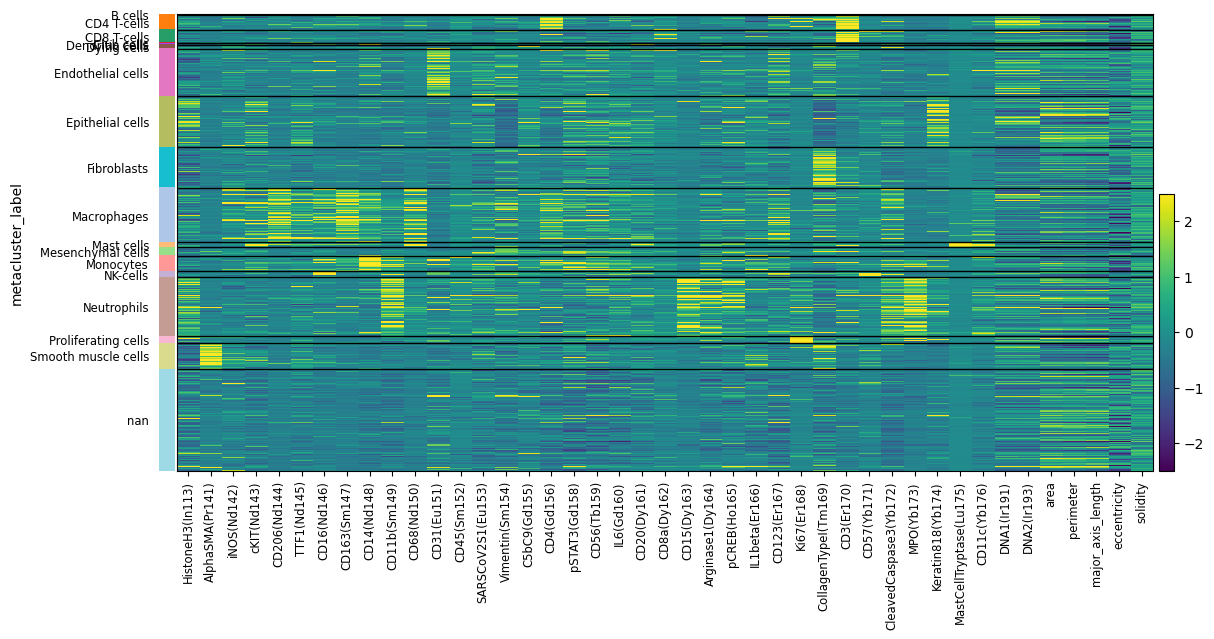

In [10]:
sc.pl.heatmap(adata, adata.var_names, groupby='metacluster_label')

## Create spatial omics dataset

In [49]:
import matplotlib 
from matplotlib.colors import ListedColormap, Normalize

# Extract colormap
var = 'metacluster_label'

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

# Create cmap for spatial omics data
cmap_labels = {i:l for i,l in enumerate(labels)}
label_cmap = {l:i for i,l in enumerate(labels)}
cmap = np.array([colors_rgb_dict[l] for l in labels])
adata.obs['meta_id'] = adata.obs[var].apply(lambda x: label_cmap.get(x,x))
adata.obs

roi                 sample disease phenotypes  \
0          20200609_ARDS_1921-01     20200609_ARDS_1921    ARDS       ARDS   
1          20200609_ARDS_1921-01     20200609_ARDS_1921    ARDS       ARDS   
2          20200609_ARDS_1921-01     20200609_ARDS_1921    ARDS       ARDS   
3          20200609_ARDS_1921-01     20200609_ARDS_1921    ARDS       ARDS   
4          20200609_ARDS_1921-01     20200609_ARDS_1921    ARDS       ARDS   
...                          ...                    ...     ...        ...   
664001  20200806_ARDS_PNE1920-09  20200806_ARDS_PNE1920    ARDS  Pneumonia   
664002  20200806_ARDS_PNE1920-09  20200806_ARDS_PNE1920    ARDS  Pneumonia   
664003  20200806_ARDS_PNE1920-09  20200806_ARDS_PNE1920    ARDS  Pneumonia   
664004  20200806_ARDS_PNE1920-09  20200806_ARDS_PNE1920    ARDS  Pneumonia   
664005  20200806_ARDS_PNE1920-09  20200806_ARDS_PNE1920    ARDS  Pneumonia   

       acquisition_id  acquisition_date  obj_id cluster_1.0  \
0           ARDS_1921          7.305364       2          32   
1           ARDS_1921          7.305364       3           6   
2           ARDS_1921          7.305364       5          21   
3           ARDS_1921          7.305364       6           5   
4           ARDS_1921          7.305364       7          21   
...               ...               ...     ...         ...   
664001   ARDS_PNE1920          7.305369    2767           6   
664002   ARDS_PNE1920          7.305369    2768          21   
664003   ARDS_PNE1920          7.305369    2769          15   
664004   ARDS_PNE1920          7.305369    2772          46   
664005   ARDS_PNE1920          7.305369    2774          30   

                                            cluster_label  \
0       32 - Proliferating cells (Ki67+, MPOdim, Histo...   
1                       06 - Fibroblasts (CollagenTypeI+)   
2       21 - Fibroblasts (CollagenTypeI+, CD56+, pSTAT...   
3                          05 - Endothelial cells (CD31+)   
4       21 - Fibroblasts (CollagenTypeI+, CD56+, pSTAT...   
...                                                   ...   
664001                  06 - Fibroblasts (CollagenTypeI+)   
664002  21 - Fibroblasts (CollagenTypeI+, CD56+, pSTAT...   
664003                     15 - Endothelial cells (CD31+)   
664004                             46 - ?(CD11bdim, IL6+)   
664005                                  30 - ?(No marker)   

          metacluster_label meta_id  
0       Proliferating cells      15  
1               Fibroblasts       8  
2               Fibroblasts       8  
3         Endothelial cells       6  
4               Fibroblasts       8  
...                     ...     ...  
664001          Fibroblasts       8  
664002          Fibroblasts       8  
664003    Endothelial cells       6  
664004              Unknown      17  
664005              Unknown      17  

[664006 rows x 11 columns]

In [50]:
# Generate spatial omics dataframe
data_name = 'Covid_IMC_2'
identifier = 'roi'
cell_id = 'obj_id'
spatial_path = spatial_omics_folder / f'{data_name}.hdf5'

# Get image id 
im_ids = sorted(adata.obs[identifier].unique())

In [51]:
adata.obs['metacluster_label'] = adata.obs['metacluster_label'].apply(lambda x: {'nan': 'Unknown'}.get(x,x))
adata.obs['metacluster_label'] = adata.obs['metacluster_label'].astype('category')
adata.obs['metacluster_label']

0         Proliferating cells
1                 Fibroblasts
2                 Fibroblasts
3           Endothelial cells
4                 Fibroblasts
                 ...         
664001            Fibroblasts
664002            Fibroblasts
664003      Endothelial cells
664004                Unknown
664005                Unknown
Name: metacluster_label, Length: 664006, dtype: category
Categories (18, object): ['B cells', 'CD4 T-cells', 'CD8 T-cells', 'Club cells', ..., 'Neutrophils', 'Proliferating cells', 'Smooth muscle cells', 'Unknown']

In [52]:
# Create spatial omics
spadata = SpatialOmics()
spl = pd.DataFrame({identifier:  im_ids})
spadata.spl = spl

# Loop through images
for im_id in tqdm(im_ids):
    # Get subset adata
    adata_subset = adata[adata.obs[identifier] == im_id, :]
    obs = adata_subset.obs.copy()
    obs.index = obs[cell_id].tolist()
    info = adata_subset.obs.iloc[0]

    # Read mask
    sample = info['sample']
    roi = info['roi']
    mask_path = masks_folder / sample / 'tiffs' /f'{roi}_full_mask.tiff'
    try:
        mask = skimage.io.imread(mask_path)
    except:
        print(f'Error for {mask_path}')
        continue 
    
    # Add single-cell data 
    spadata.obs[im_id] = obs
    spadata.X[im_id] = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names.tolist(), index=obs[cell_id].tolist())
    spadata.var[im_id] = adata_subset.var
    
    # Filter out cell in mask not present in dataframe
    cell_list = obs[cell_id].tolist()
    mask_list = list(np.unique(mask))
    diff = list(set(mask_list).difference(cell_list))
    mask = np.where(np.isin(mask, diff), 0, mask)

    # Add mask to spadata
    spadata.masks[im_id] = {'cellmasks': mask}
    ath.pp.extract_centroids(spadata, im_id, mask_key='cellmasks')

# Add colormap to spatial omics data
spadata.uns['cmaps'].update({'meta_id': ListedColormap(cmap / 255)})
spadata.uns['cmap_labels'].update({'meta_id': cmap_labels})



  0%|          | 0/237 [00:00<?, ?it/s]

In [53]:
adata.var_names

Index(['HistoneH3(In113)', 'AlphaSMA(Pr141)', 'iNOS(Nd142)', 'cKIT(Nd143)',
       'CD206(Nd144)', 'TTF1(Nd145)', 'CD16(Nd146)', 'CD163(Sm147)',
       'CD14(Nd148)', 'CD11b(Sm149)', 'CD68(Nd150)', 'CD31(Eu151)',
       'CD45(Sm152)', 'SARSCoV2S1(Eu153)', 'Vimentin(Sm154)', 'C5bC9(Gd155)',
       'CD4(Gd156)', 'pSTAT3(Gd158)', 'CD56(Tb159)', 'IL6(Gd160)',
       'CD20(Dy161)', 'CD8a(Dy162)', 'CD15(Dy163)', 'Arginase1(Dy164)',
       'pCREB(Ho165)', 'IL1beta(Er166)', 'CD123(Er167)', 'Ki67(Er168)',
       'CollagenTypeI(Tm169)', 'CD3(Er170)', 'CD57(Yb171)',
       'CleavedCaspase3(Yb172)', 'MPO(Yb173)', 'Keratin818(Yb174)',
       'MastCellTryptase(Lu175)', 'CD11c(Yb176)', 'DNA1(Ir191)', 'DNA2(Ir193)',
       'area', 'perimeter', 'major_axis_length', 'eccentricity', 'solidity'],
      dtype='object')

20200609_ARDS_1921-01


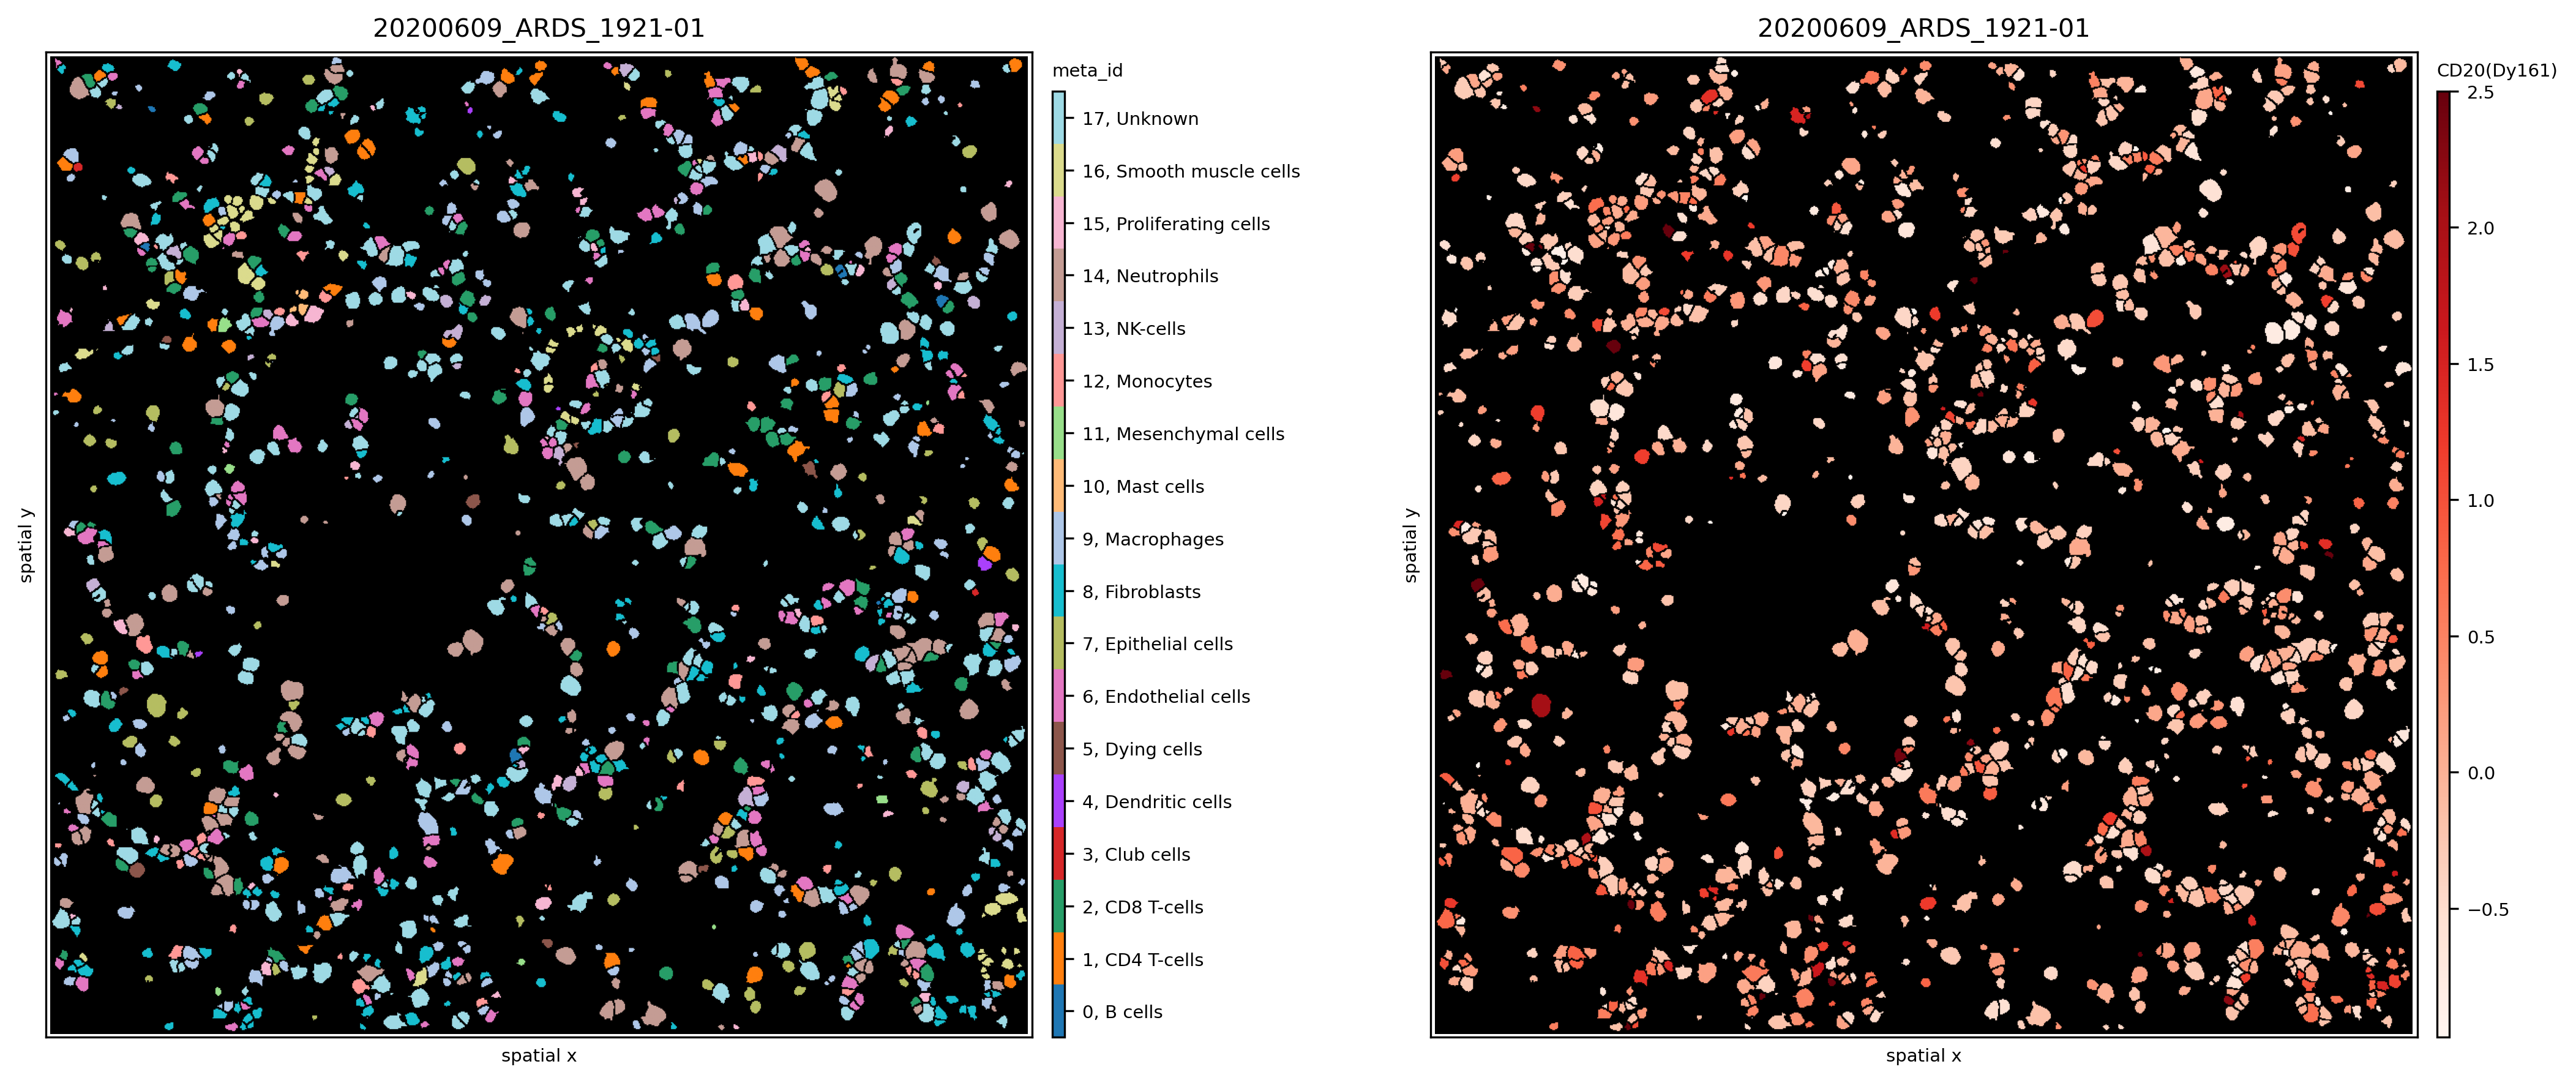

In [55]:
# Test image with masks

for im_id in spadata.spl[identifier].unique():
    print(im_id)
    # im_id = str(im_id)
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
    ath.pl.spatial(spadata, im_id, 'meta_id', mode='mask', ax=axs.flat[0],background_color='black')
    ath.pl.spatial(spadata, im_id, 'CD20(Dy161)', mode='mask', ax=axs.flat[1], background_color='black')
    break

In [56]:
# Create graph for different type
from athena.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS

for im_id in spadata.spl[identifier].unique():
    # kNN graph
    config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
    config['builder_params']['n_neighbors'] = 6 # set parameter k
    ath.graph.build_graph(spadata, im_id, builder_type='knn', mask_key='cellmasks', config=config)

    # # radius graph
    # config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
    # config['builder_params']['radius'] = 20 # set radius
    # ath.graph.build_graph(spadata, im_id, builder_type='radius', mask_key='cellmasks', config=config)

    # # contact graph - this takes some time
    # ath.graph.build_graph(spadata, im_id, builder_type='contact', mask_key='cellmasks')

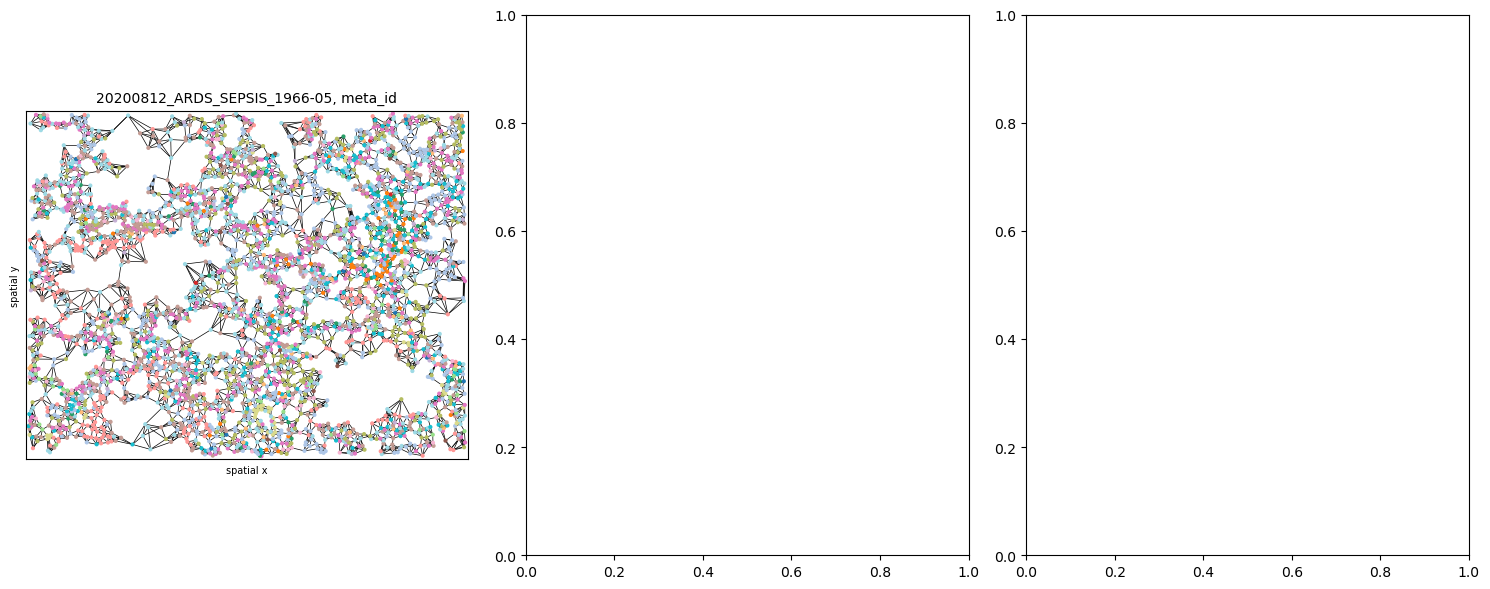

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6), dpi=100)
ath.pl.spatial(spadata, im_id, 'meta_id', edges=True, graph_key='knn', ax=axs.flat[0], cbar=False)
# ath.pl.spatial(spadata, im_id, 'meta_id', edges=True, graph_key='radius', ax=axs.flat[1], cbar=False)
# ath.pl.spatial(spadata, im_id, 'meta_id', edges=True, graph_key='contact', ax=axs.flat[2], cbar=False)


In [58]:
# Save data
spatial_path = spatial_omics_folder / f'{data_name}.hdf5'
spadata.to_h5py(spatial_path)

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '20200609_ARDS_1921-01'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '20200609_ARDS_1921-02'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '20200609_ARDS_1921-03'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; yo

File `Covid_IMC_2.hdf5` saved to y:\coskun-lab\Thomas\11_snowflakes\data\spatial_omics_graph_external\Covid_IMC_2.hdf5
File size: 1092.95 MB


c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '20200812_ARDS_SEPSIS_1966-05'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [59]:
spadata.spl

roi
0           20200609_ARDS_1921-01
1           20200609_ARDS_1921-02
2           20200609_ARDS_1921-03
3           20200609_ARDS_1921-04
4           20200609_ARDS_1921-05
..                            ...
232  20200812_ARDS_SEPSIS_1966-01
233  20200812_ARDS_SEPSIS_1966-02
234  20200812_ARDS_SEPSIS_1966-03
235  20200812_ARDS_SEPSIS_1966-04
236  20200812_ARDS_SEPSIS_1966-05

[237 rows x 1 columns]

# Brain 

In [17]:
import scipy.io
mat = scipy.io.loadmat(r'Y:\coskun-lab\Thomas\graph\BrainData\BRAIN_IMC_CellType\BrM_001C1.mat')

In [25]:
mat['cellTypes'].shape

(2253, 1)